<a href="https://colab.research.google.com/github/ziatdinovmax/AugmentedGaussianProcess/blob/main/sGPBO_forrester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks compares Bayesian optimization with classical GP and GP augmented by a structured probabilistic model (as GP mean function). We are going to use a slightly modified version of the [Forester function](https://www.sfu.ca/~ssurjano/forretal08.html) that has local and global minima with the goal to identify the global minima using the minumum number of steps.

*Prepared by Maxim Ziatdinov (August 2021)*

Install NumPyro (for [iterative No-U-Turn Sampler](https://github.com/pyro-ppl/numpyro/wiki/Iterative-NUTS))

In [1]:
!pip install -q numpyro

Imports:

In [2]:
from typing import Union, Dict, Type

from functools import partial

import jax.numpy as jnp
from jax import jit
import jax.random as jra
from jax.scipy import linalg as jLA
import jax
from jax.interpreters import xla

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

import numpy as onp
import matplotlib.pyplot as plt

numpyro.enable_x64()

Define common kernel functions:

In [3]:
def _sqrt(x, eps=1e-12):
    return jnp.sqrt(x + eps)

def add_jitter(x, jitter=1e-6):
    return x + jitter

def square_scaled_distance(X: jnp.ndarray, Z: jnp.ndarray,
                           lengthscale: Union[jnp.ndarray, float] = 1.
                           ) -> jnp.ndarray:
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = jnp.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)

@jit
def RBFKernel(X: jnp.ndarray, Z: jnp.ndarray,
              params: Dict[str, jnp.ndarray],
              noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    k = params["k_scale"] * jnp.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k


@jit
def MaternKernel(X: jnp.ndarray, Z: jnp.ndarray,
                 params: Dict[str, jnp.ndarray],
                 noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = params["k_scale"] * (1 + sqrt5_r + (5/3) * r2) * jnp.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k

## Regular GP

Define a base class for GP:

In [4]:
class ExactGP:

    def __init__(self, input_dim, kernel, mean_fn=None):  # e.g. ExactGP(input_dim=2, kernel=RBFKernel)
        xla._xla_callable.cache_clear()
        self.input_dim = input_dim
        self.kernel = kernel
        self.mean_fn = mean_fn
        self.X_train = None
        self.y_train = None

    def model(self, X, y):
        """GP model"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters and noise
        with numpyro.plate('k_param', self.input_dim):  # allows using ARD kernel for ndim > 2
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1.0))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1.0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            f_loc += self.mean_fn(X).squeeze()
        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard Gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

    def fit(self, rng_key, X, y,
            num_warmup=2000, num_samples=1000, num_chains=1, chain_dim=False,
            progress_bar = True, print_summary=True):
        """
        Run MCMC to infer the GP model parameters
        """
        self.X_train = X
        self.y_train = y

        init_strategy = numpyro.infer.init_to_median(num_samples=10)
        kernel = NUTS(self.model, init_strategy=init_strategy)
        mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            progress_bar=progress_bar,
            jit_model_args=False
        )
        mcmc.run(rng_key, X, y)
        if print_summary:
            mcmc.print_summary()
        return mcmc.get_samples(group_by_chain=chain_dim)

    @partial(jit, static_argnames='self')
    def _predict(self, rng_key, X_test, params, **kwargs):
        """Prediction with a single sample of kernel parameters"""
        noise = params["noise"]
        y_residual = self.y_train
        if self.mean_fn is not None:
            y_residual -= self.mean_fn(self.X_train, params).squeeze()
        # compute kernel matrices for train and test data
        k_pp = self.kernel(X_test, X_test, params, noise, **kwargs)
        k_pX = self.kernel(X_test, self.X_train, params, jitter=0.0)
        k_XX = self.kernel(self.X_train, self.X_train, params, noise, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        y_mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, y_residual))
        if self.mean_fn is not None:
            y_mean += self.mean_fn(X_test, params).squeeze()
        # draw a sample from the posterior predictive for a given set of hyperparameters
        y_sample = (jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * 
                    jra.normal(rng_key, X_test.shape[:1])) + y_mean
        return y_mean, y_sample
    
    @partial(jit, static_argnames='self')
    def predict(self, rng_key, samples, X_test, **kwargs):
        """Make prediction using sampled GP parameters"""
        chain_dim = samples["k_length"].ndim == 3
        if chain_dim:
            samples_ = {}
            for k, v in samples.items():
                samples_[k] = v.reshape(-1, v.shape[-1]) if v.ndim == 3 else v.flatten()
            samples = samples_
        num_samples = samples["k_length"].shape[0]
        vmap_args = (jra.split(rng_key, num_samples), samples)
        predictive = jax.vmap(lambda params:
                        self._predict(params[0], X_test, params[1]))
        y_means, y_sampled = predictive(vmap_args)
        return y_means.mean(0), y_sampled

Define acquisition function for Bayesian optimization and active learning:

In [5]:
def EI(rng_key: jnp.ndarray, model: Type[ExactGP],
       posterior_samples: Dict[str, jnp.ndarray],
       X: jnp.ndarray, xi: float = 0.01) -> jnp.ndarray:
    """
    Expected Improvement
    """
    y_mean, y_sampled = model.predict(rng_key, posterior_samples, X)
    mean, sigma = y_sampled.mean(0), y_sampled.std(0)
    u = (mean - y_mean.max() - xi) / sigma
    normal = dist.Normal(jnp.zeros_like(u), jnp.ones_like(u))
    ucdf = normal.cdf(u)
    updf = jnp.exp(normal.log_prob(u))
    return sigma * (updf + u * ucdf)


def UCB(rng_key: jnp.ndarray, model: Type[ExactGP],
        posterior_samples: Dict[str, jnp.ndarray],
        X: jnp.ndarray, beta: float = .25) -> jnp.ndarray:
    """
    Upper confidence bound
    """
    _, y_sampled = model.predict(rng_key, posterior_samples, X)
    mean, var= y_sampled.mean(0), y_sampled.var(0)
    delta = jnp.sqrt(beta * var)
    return mean - delta


def UE(rng_key: jnp.ndarray,
       model: Type[ExactGP],
       posterior_samples: Dict[str, jnp.ndarray],
       X: jnp.ndarray) -> jnp.ndarray:
    """Uncertainty-based exploration (aka kriging)"""
    y_mean, y_sampled = model.predict(rng_key, posterior_samples, X)
    return y_sampled.var(0)

def Thompson(rng_key: jnp.ndarray,
             model: Type[ExactGP],
             posterior_samples: Dict[str, jnp.ndarray],
             X: jnp.ndarray, chain_dim: bool = False) -> jnp.ndarray:
    """Thompson sampling"""
    idx = jra.randint(rng_key, (1,), 0, len(posterior_samples["k_length"]))
    if chain_dim:
        samples = {k: v.mean(0)[idx] for (k, v) in posterior_samples.items()}
    else:
        samples = {k: v[idx] for (k, v) in posterior_samples.items()}
    _, tsample = model._predict(rng_key, X, samples)
    return tsample.squeeze()

Define our objective function:

In [6]:
def forrester_func(x, params):
    return (params["A"] * x + params["x01"])**2 * jnp.sin(params["B"] * x + params["x02"])

def get_data(N=100, noise_level=0):
    onp.random.seed(1)
    X = jnp.linspace(0, 1, N)
    X_test = jnp.linspace(0, 1, N*2)
    truefunc = forrester_func(X, {"A": 5, "x01": -2, "B": 12, "x02": -4})
    Y = truefunc + noise_level * onp.random.normal(size=X.shape)
    return X[:, None], Y, truefunc, X_test[:, None]

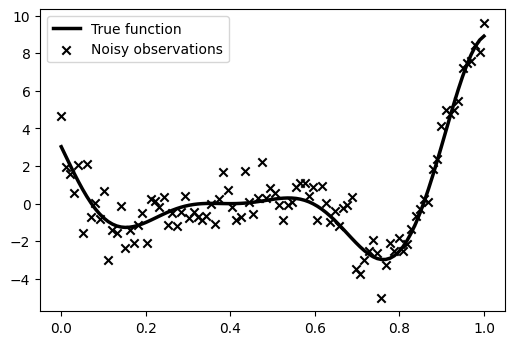

In [7]:
plt.figure(dpi=100)
X, Y, truefunc, X_test = get_data(noise_level=1)
plt.scatter(X, Y, marker='x', c='k', zorder=0, label='Noisy observations')
plt.plot(X, truefunc, c='k', lw=2.5, zorder=1, label='True function')
plt.legend()

### Standard GP - Thompson

Do Bayesian optimization with Thompson sampling:

In [8]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 5687.55it/s, 7 steps of size 8.10e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.22      1.00      0.05      3.72   6671.13      1.00
    k_scale      1.65      1.77      1.12      0.04      3.54   8673.25      1.00
      noise      1.74      1.72      1.25      0.18      3.56   6974.92      1.00

Number of divergences: 0


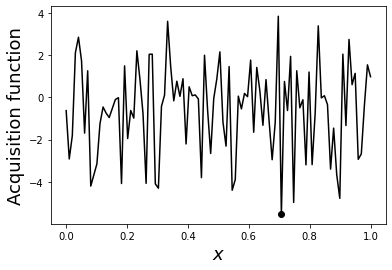

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 5171.18it/s, 7 steps of size 6.99e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.70      2.42      1.04      0.03      3.60   5414.11      1.00
    k_scale      2.51      2.49      1.78      0.05      5.30   7842.81      1.00
      noise      2.27      2.07      1.67      0.16      4.68   6860.27      1.00

Number of divergences: 0


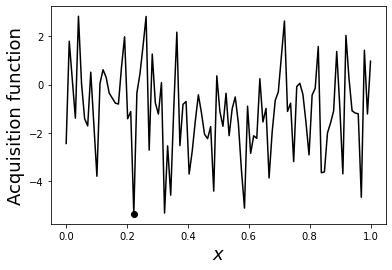

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4894.74it/s, 7 steps of size 7.41e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.17      1.03      0.04      3.63   6162.82      1.00
    k_scale      1.93      2.05      1.32      0.05      4.17   7873.98      1.00
      noise      2.64      1.91      2.14      0.46      4.92   6921.92      1.00

Number of divergences: 0


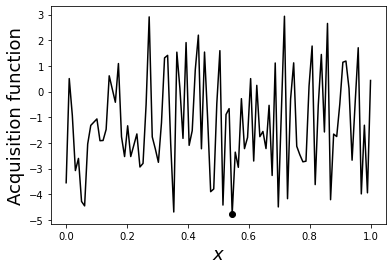

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4556.72it/s, 7 steps of size 6.86e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.78      2.35      1.08      0.04      3.87   6477.96      1.00
    k_scale      1.57      1.73      1.05      0.06      3.36   7357.85      1.00
      noise      2.72      1.73      2.27      0.68      4.91   6835.73      1.00

Number of divergences: 0


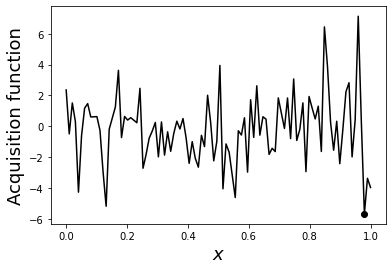

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3743.76it/s, 7 steps of size 7.49e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.41      2.09      0.77      0.03      3.23   5807.55      1.00
    k_scale      2.08      3.14      1.05      0.04      4.92   1267.00      1.01
      noise      9.51      5.06      8.61      1.52     16.65   2933.33      1.00

Number of divergences: 12


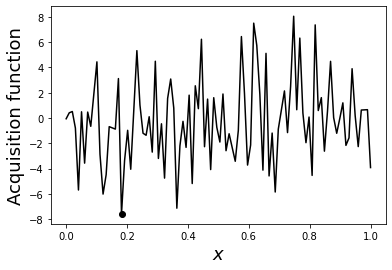

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4217.90it/s, 7 steps of size 6.54e-01. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.31      2.11      0.69      0.03      3.01   4010.59      1.00
    k_scale      2.58      3.93      1.14      0.02      6.78   1024.22      1.01
      noise      8.30      4.62      7.75      0.29     14.15   1852.96      1.00

Number of divergences: 19


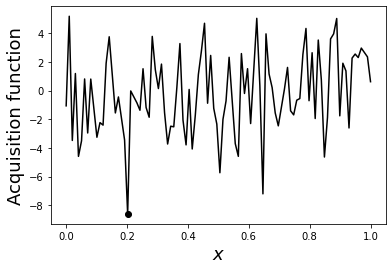

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3826.60it/s, 7 steps of size 4.45e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.16      1.93      0.58      0.03      2.73   4613.42      1.00
    k_scale      2.97      4.30      1.27      0.04      7.91   1252.12      1.00
      noise      7.46      4.32      6.99      0.32     12.75   1661.75      1.00

Number of divergences: 5


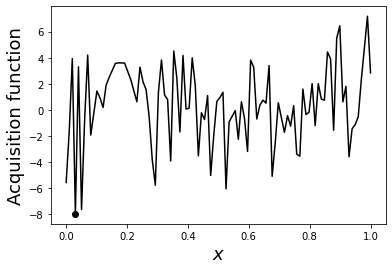

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3767.20it/s, 7 steps of size 3.77e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.11      1.86      0.52      0.03      2.64   3631.65      1.00
    k_scale      3.38      4.81      1.41      0.03      9.07   1003.02      1.01
      noise      6.63      4.09      6.36      0.22     11.58   1324.02      1.01

Number of divergences: 20


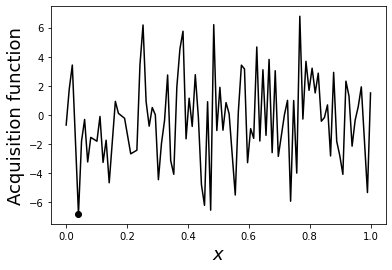

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3934.18it/s, 7 steps of size 6.29e-01. acc. prob=0.71]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.14      1.92      0.52      0.03      2.73   3326.99      1.00
    k_scale      3.22      4.43      1.34      0.02      8.86   1098.01      1.01
      noise      6.54      3.86      6.30      0.41     11.41   1329.43      1.00

Number of divergences: 21


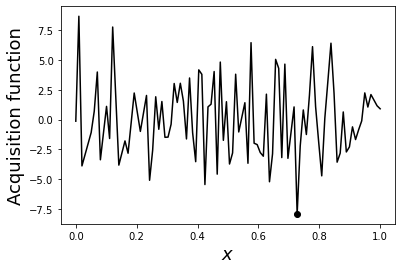

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3346.41it/s, 15 steps of size 2.82e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.90      1.55      0.28      0.03      2.35   1823.30      1.00
    k_scale      4.64      5.58      2.09      0.03     12.18    953.44      1.01
      noise      5.47      4.06      5.26      0.25     10.71    731.52      1.01

Number of divergences: 1


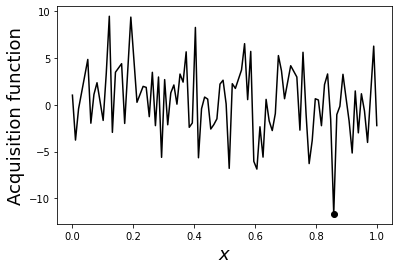

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1896.47it/s, 7 steps of size 4.08e-01. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.96      1.71      0.37      0.02      2.39   3041.96      1.00
    k_scale      3.63      4.56      1.63      0.05      9.64   1104.96      1.01
      noise      5.63      3.69      5.47      0.36     10.29   1217.31      1.01

Number of divergences: 0


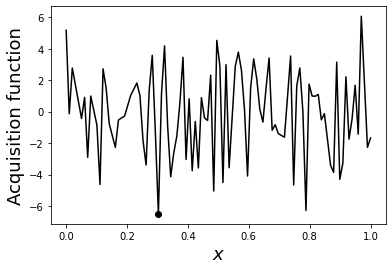

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3041.89it/s, 7 steps of size 3.22e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.99      1.82      0.37      0.02      2.43   3200.30      1.00
    k_scale      3.47      4.29      1.62      0.02      9.12   1186.58      1.01
      noise      5.33      3.27      5.26      0.45      9.52   1179.39      1.01

Number of divergences: 2


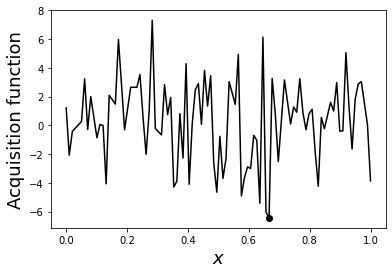

In [9]:
def plot_result(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.scatter(x[idx], obj.min(), c='k')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()


exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = ExactGP(1, RBFKernel)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10, chain_dim=False)
    # Compute acquisition 
    obj = Thompson(rng_key_predict, gp_model, posterior_samples, X_test, chain_dim=False)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

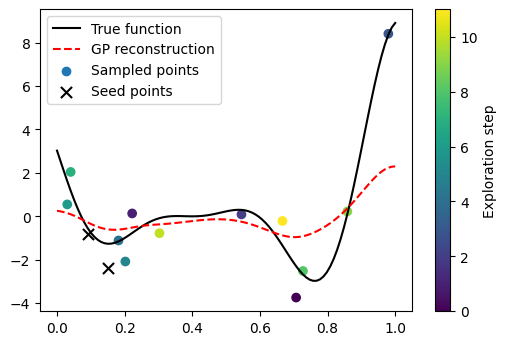

In [10]:
def plot_final_result(X_train, y_train, y_pred):
    plt.figure(dpi=100)
    plt.scatter(X_train[2:], y_train[2:], c=jnp.arange(len(X_train[2:])),
                cmap='viridis', label="Sampled points", zorder=0)
    plt.colorbar(label="Exploration step")
    plt.scatter(X_train[:2], y_train[:2], marker='x', s=64, c='k', label="Seed points", zorder=1)
    plt.plot(X, truefunc, c='k', label='True function', zorder=0)
    plt.plot(X, y_pred, '--', c='red', label='GP reconstruction', zorder=0)
    plt.legend()
    plt.show()

y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)
plot_final_result(X_train, y_train, y_pred)

### Standard GP - UCB

Do Bayesian optimization with upper confidence bound acqusition function:

In [11]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 5444.05it/s, 7 steps of size 8.10e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.22      1.00      0.05      3.72   6671.13      1.00
    k_scale      1.65      1.77      1.12      0.04      3.54   8673.25      1.00
      noise      1.74      1.72      1.25      0.18      3.56   6974.92      1.00

Number of divergences: 0


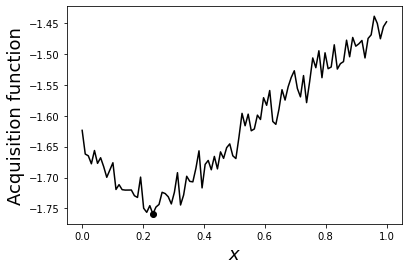

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 5268.37it/s, 7 steps of size 7.23e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.71      2.32      1.01      0.04      3.73   6588.14      1.00
    k_scale      1.42      1.55      0.94      0.06      3.06   7807.56      1.00
      noise      1.63      1.36      1.25      0.23      3.13   6928.71      1.00

Number of divergences: 0


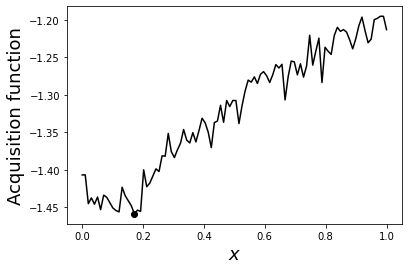

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4642.90it/s, 7 steps of size 7.71e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.63      2.06      0.99      0.03      3.60   7198.30      1.00
    k_scale      1.64      1.77      1.12      0.06      3.48   7869.99      1.00
      noise      1.51      1.19      1.19      0.26      2.94   6630.13      1.00

Number of divergences: 0


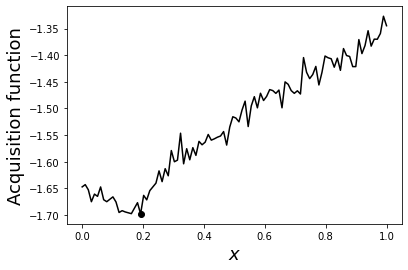

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4333.46it/s, 7 steps of size 7.07e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      2.09      1.00      0.04      3.71   7062.70      1.00
    k_scale      1.55      1.70      1.05      0.07      3.29   7153.88      1.00
      noise      1.33      0.97      1.08      0.27      2.43   6621.05      1.00

Number of divergences: 0


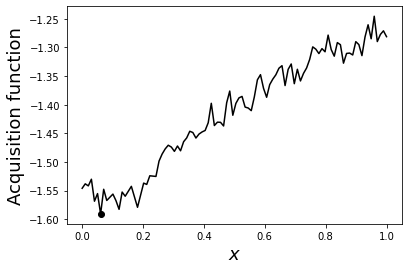

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4588.42it/s, 7 steps of size 6.63e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.61      2.16      0.95      0.03      3.61   6935.16      1.00
    k_scale      1.29      1.50      0.81      0.05      2.87   6062.78      1.00
      noise      2.40      1.39      2.06      0.69      4.16   6723.45      1.00

Number of divergences: 0


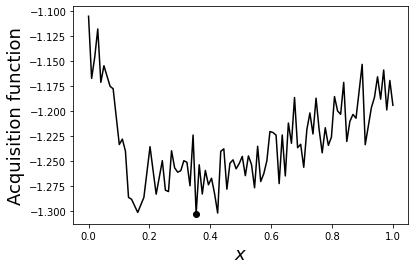

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4298.53it/s, 7 steps of size 7.89e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.62      2.20      0.97      0.02      3.49   6608.05      1.00
    k_scale      1.20      1.38      0.77      0.05      2.58   7413.35      1.00
      noise      2.17      1.20      1.88      0.65      3.75   5834.18      1.00

Number of divergences: 0


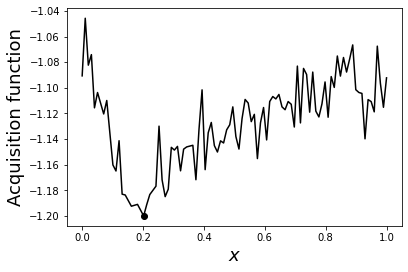

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3875.81it/s, 7 steps of size 6.67e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.58      2.13      0.93      0.02      3.58   7157.74      1.00
    k_scale      1.29      1.47      0.85      0.04      2.79   5645.16      1.00
      noise      2.15      1.11      1.90      0.76      3.72   5632.81      1.00

Number of divergences: 1


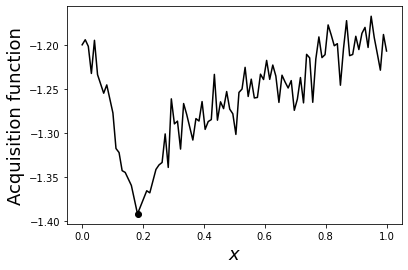

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2776.23it/s, 7 steps of size 7.82e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.58      2.20      0.94      0.02      3.52   6301.13      1.00
    k_scale      1.32      1.49      0.87      0.06      2.78   7311.58      1.00
      noise      1.95      1.00      1.73      0.63      3.29   6240.48      1.00

Number of divergences: 0


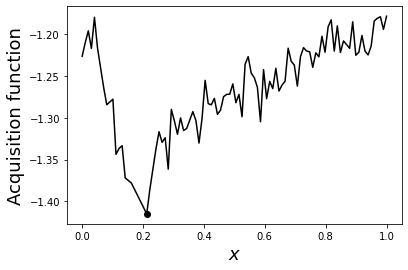

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3309.54it/s, 7 steps of size 6.81e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.58      2.13      0.94      0.03      3.50   6965.86      1.00
    k_scale      1.24      1.44      0.81      0.05      2.67   7011.74      1.00
      noise      1.88      0.88      1.69      0.71      3.12   6578.23      1.00

Number of divergences: 0


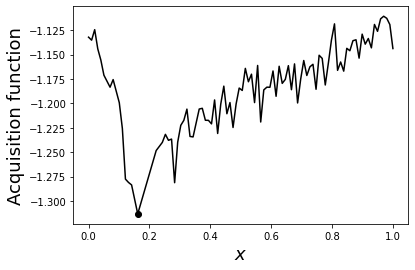

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3522.81it/s, 7 steps of size 7.37e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.55      2.02      0.92      0.02      3.45   7750.33      1.00
    k_scale      1.30      1.43      0.86      0.05      2.81   6433.27      1.00
      noise      1.75      0.81      1.58      0.67      2.88   6349.67      1.00

Number of divergences: 0


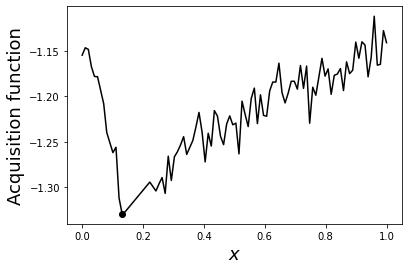

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3644.80it/s, 7 steps of size 7.35e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.52      2.05      0.90      0.03      3.51   7050.03      1.00
    k_scale      1.32      1.43      0.89      0.06      2.80   6557.32      1.00
      noise      1.65      0.74      1.51      0.59      2.66   5544.40      1.00

Number of divergences: 0


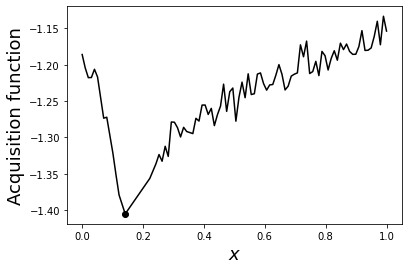

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3465.65it/s, 7 steps of size 8.26e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.57      2.19      0.92      0.03      3.52   7451.52      1.00
    k_scale      1.28      1.38      0.85      0.05      2.72   6669.71      1.00
      noise      1.59      0.67      1.45      0.64      2.54   6474.21      1.00

Number of divergences: 0


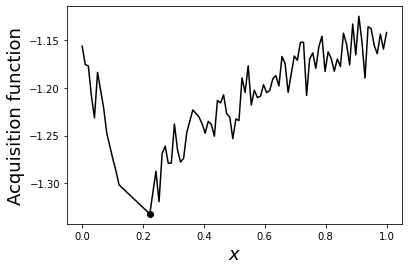

In [12]:
exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = ExactGP(1, RBFKernel)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10)
    # Compute acquisition 
    obj = UCB(rng_key_predict, gp_model, posterior_samples, X_test)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

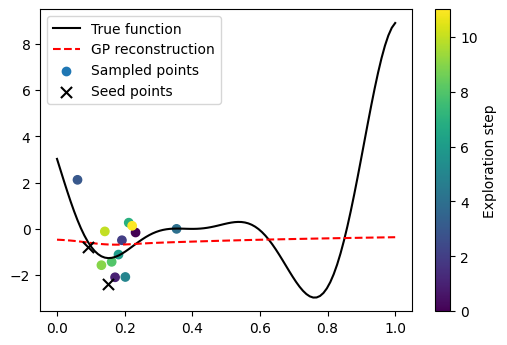

In [13]:
y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)

plot_final_result(X_train, y_train, y_pred)

## GP with probabilistic mean function

Her we diefine our probabilistic function as two inverted peaks. In another words, it is a very rough guess about the true form of our objective function. Nevertheless, as we show below, it will allow for a much more efficient Bayesian optimization.

We are going to write our GP models with probabilistic mean functions by subclassing the base GP class and redefining the model.

In [14]:
def doubleLorentzfunc(x, params):
    return (params["y0"] - (params["A1"]/((x-params["x01"])**2+params["w1"]**2)**(1/2) +
            params["A2"]/((x-params["x02"])**2+params["w2"]**2)**(1/2)))

In [15]:
class GP1(ExactGP):

    def __init__(self, input_dim, kernel, mean_fn):
        super(GP1, self).__init__(input_dim, kernel, mean_fn)

    def model(self, X, y):

        f_loc = jnp.zeros(X.shape[0])

        # Mean function prameters
        y0 = numpyro.sample("y0", dist.Uniform(-10, 10))
        x01 = numpyro.sample("x01", dist.Uniform(0.1, 0.5))
        x02 = numpyro.sample("x02", dist.Uniform(0.5, 0.9))
        A1 = numpyro.sample("A1", dist.LogNormal(0, 1))
        A2 = numpyro.sample("A2", dist.LogNormal(0, 1))
        w1 = numpyro.sample("w1", dist.HalfNormal(.1))
        w2 = numpyro.sample("w2", dist.HalfNormal(.1))
            # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"y0": y0, "x01": x01, "x02": x02,
                          "A1": A1, "A2": A2, "w1": w1, "w2": w2}
        if self.mean_fn is not None:
            f_loc += self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

### Structured GP - Thompson

Do Bayesian optimization with Thompson sampling:

In [16]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2769.04it/s, 31 steps of size 1.41e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.92      0.67      0.74      0.04      1.87   6013.08      1.00
         A2      1.26      1.07      0.93      0.05      2.73   6650.42      1.00
k_length[0]      1.68      2.20      1.02      0.03      3.68   7064.89      1.00
    k_scale      1.60      2.11      0.97      0.05      3.45   6481.10      1.00
      noise      1.19      1.40      0.77      0.04      2.59   6984.56      1.00
         w1      0.09      0.06      0.08      0.00      0.17   7149.46      1.00
         w2      0.08      0.06      0.07      0.00      0.16   8437.47      1.00
        x01      0.34      0.10      0.35      0.19      0.50   6464.31      1.00
        x02      0.70      0.11      0.70      0.51      0.86   8307.79      1.00
         y0      4.44      2.88      4.48      0.22      9.44   5167.48      1.00

Number of divergences: 60


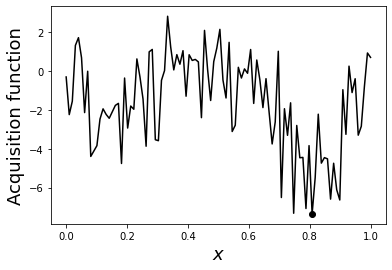

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2317.40it/s, 31 steps of size 1.02e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.92      0.70      0.72      0.05      1.92   4057.62      1.00
         A2      0.84      0.62      0.67      0.05      1.72   4380.47      1.00
k_length[0]      1.74      2.20      1.10      0.07      3.72   6035.67      1.00
    k_scale      1.54      1.97      0.93      0.06      3.37   5816.38      1.00
      noise      1.07      1.20      0.71      0.04      2.25   5822.32      1.00
         w1      0.08      0.06      0.07      0.00      0.17   6164.94      1.00
         w2      0.09      0.06      0.08      0.00      0.18   6176.24      1.00
        x01      0.35      0.10      0.36      0.21      0.50   3727.28      1.00
        x02      0.66      0.11      0.64      0.50      0.84   3855.25      1.00
         y0      3.76      2.85      3.55     -0.67      8.55   3338.15      1.00

Number of divergences: 186


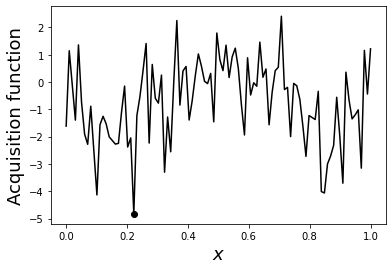

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2317.83it/s, 31 steps of size 1.70e-01. acc. prob=0.75]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.53      0.39      0.43      0.05      1.05   3616.10      1.00
         A2      0.73      0.52      0.58      0.06      1.45   2393.04      1.00
k_length[0]      1.69      2.36      1.01      0.05      3.59   5432.79      1.00
    k_scale      1.63      2.02      0.98      0.05      3.70   4199.71      1.00
      noise      1.99      1.79      1.52      0.08      3.90   2885.51      1.00
         w1      0.11      0.07      0.10      0.00      0.20   4600.76      1.00
         w2      0.09      0.06      0.08      0.00      0.18   4032.30      1.00
        x01      0.30      0.14      0.32      0.12      0.49   1573.95      1.01
        x02      0.70      0.11      0.70      0.56      0.90   2612.34      1.01
         y0      3.16      2.65      2.84     -0.98      7.63   1524.38      1.01

Number of divergences: 306


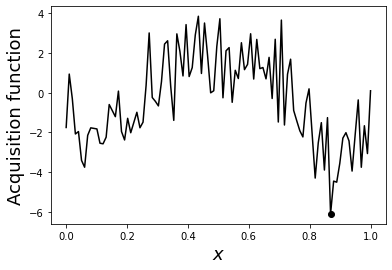

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2030.76it/s, 31 steps of size 1.33e-01. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.55      0.41      0.45      0.06      1.09   3718.12      1.00
         A2      0.77      0.55      0.62      0.07      1.55   2317.88      1.00
k_length[0]      1.67      2.13      1.03      0.03      3.58   5939.19      1.00
    k_scale      1.55      1.88      0.97      0.04      3.43   4998.80      1.00
      noise      1.89      1.52      1.49      0.21      3.67   3059.82      1.00
         w1      0.10      0.07      0.09      0.00      0.20   4605.39      1.00
         w2      0.08      0.06      0.07      0.00      0.17   4684.03      1.00
        x01      0.28      0.14      0.28      0.10      0.47   1597.35      1.00
        x02      0.67      0.09      0.66      0.50      0.79   3769.41      1.00
         y0      3.63      2.60      3.31     -0.52      8.07   1655.56      1.00

Number of divergences: 284


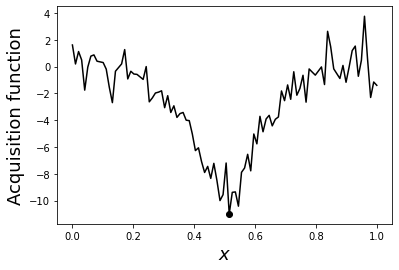

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1894.93it/s, 47 steps of size 1.50e-01. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.50      0.34      0.41      0.06      0.94   3111.12      1.00
         A2      0.64      0.41      0.55      0.09      1.23   1859.88      1.01
k_length[0]      1.74      2.20      1.05      0.04      3.81   4265.31      1.00
    k_scale      1.53      1.81      0.97      0.04      3.33   5458.26      1.00
      noise      1.48      1.32      1.13      0.14      2.93   3629.30      1.00
         w1      0.11      0.06      0.10      0.02      0.21   3432.78      1.00
         w2      0.09      0.06      0.08      0.00      0.17   4384.73      1.00
        x01      0.19      0.09      0.15      0.10      0.34   2427.10      1.00
        x02      0.73      0.06      0.72      0.64      0.84   4330.07      1.00
         y0      3.89      2.53      3.67     -0.14      8.17   1702.09      1.01

Number of divergences: 129


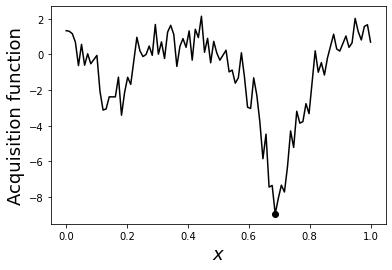

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1553.10it/s, 31 steps of size 1.55e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.48      0.36      0.39      0.06      0.97   2557.46      1.01
         A2      0.44      0.33      0.35      0.04      0.85   3430.70      1.00
k_length[0]      1.71      2.17      1.06      0.04      3.66   5937.46      1.00
    k_scale      1.61      1.92      1.00      0.06      3.56   3324.36      1.00
      noise      1.83      1.32      1.47      0.32      3.43   3452.59      1.00
         w1      0.12      0.06      0.12      0.00      0.21    906.39      1.01
         w2      0.12      0.06      0.11      0.02      0.21   3165.10      1.00
        x01      0.21      0.10      0.17      0.10      0.36   3007.27      1.00
        x02      0.77      0.08      0.79      0.64      0.90   4325.51      1.00
         y0      2.90      2.11      2.70     -0.48      6.35   2578.51      1.00

Number of divergences: 173


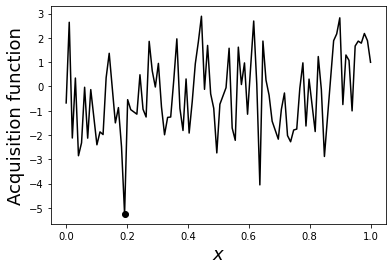

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1591.70it/s, 15 steps of size 1.16e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.46      0.35      0.37      0.04      0.90   2056.61      1.00
         A2      0.43      0.33      0.33      0.04      0.85   2417.18      1.00
k_length[0]      1.74      2.33      1.05      0.03      3.81   5766.95      1.00
    k_scale      1.62      2.08      0.97      0.02      3.66   5229.73      1.00
      noise      1.55      1.06      1.29      0.27      2.84   3503.07      1.00
         w1      0.12      0.07      0.12      0.02      0.23   3251.33      1.00
         w2      0.12      0.06      0.11      0.02      0.21   2688.12      1.00
        x01      0.21      0.10      0.17      0.10      0.37   2341.16      1.00
        x02      0.78      0.08      0.79      0.66      0.90   3673.83      1.00
         y0      2.89      2.17      2.68     -0.67      6.42   2249.87      1.00

Number of divergences: 126


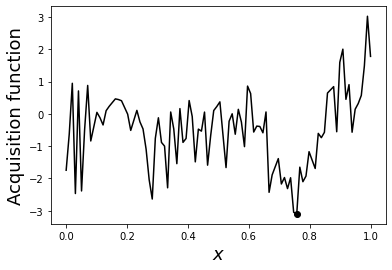

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1368.06it/s, 15 steps of size 9.55e-02. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.51      0.38      0.42      0.04      1.00   2580.69      1.00
         A2      0.40      0.30      0.31      0.07      0.79   2038.87      1.00
k_length[0]      1.70      2.16      1.04      0.04      3.76   4776.73      1.00
    k_scale      1.59      1.95      0.99      0.03      3.46   4230.81      1.00
      noise      1.91      1.43      1.51      0.33      3.78   1595.05      1.00
         w1      0.12      0.07      0.11      0.01      0.22   2658.90      1.00
         w2      0.07      0.05      0.05      0.01      0.15   1405.59      1.00
        x01      0.21      0.10      0.17      0.10      0.37   1960.77      1.00
        x02      0.77      0.04      0.77      0.72      0.84   2392.53      1.00
         y0      3.21      2.24      3.00     -0.33      7.09   2127.07      1.01

Number of divergences: 173


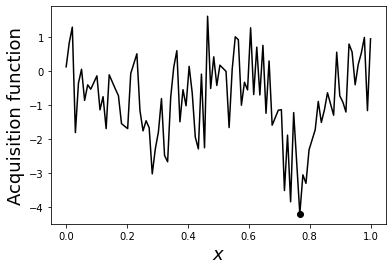

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1258.47it/s, 31 steps of size 1.13e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.53      0.38      0.43      0.06      1.03   3767.27      1.00
         A2      0.45      0.31      0.36      0.09      0.86   3764.23      1.00
k_length[0]      1.69      2.13      1.03      0.04      3.73   5890.16      1.00
    k_scale      1.61      1.93      0.99      0.04      3.53   5691.68      1.00
      noise      1.93      1.29      1.59      0.41      3.56   2940.24      1.01
         w1      0.12      0.06      0.12      0.02      0.23   4645.89      1.00
         w2      0.08      0.05      0.06      0.01      0.15   2752.52      1.00
        x01      0.21      0.10      0.17      0.10      0.36   2823.75      1.00
        x02      0.77      0.04      0.77      0.72      0.83   2893.38      1.00
         y0      3.32      2.23      3.12     -0.35      6.96   3279.69      1.00

Number of divergences: 12


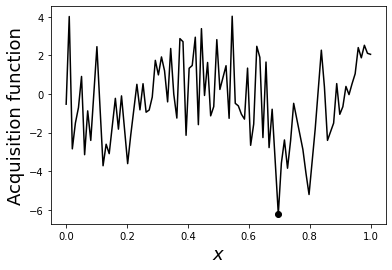

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1294.57it/s, 15 steps of size 1.34e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.50      0.36      0.41      0.05      0.97   3419.93      1.00
         A2      0.52      0.35      0.43      0.09      0.99   3072.56      1.00
k_length[0]      1.71      2.29      1.04      0.05      3.71   6486.00      1.00
    k_scale      1.59      1.95      0.98      0.04      3.54   6044.00      1.00
      noise      2.19      1.24      1.91      0.66      3.83   3676.90      1.00
         w1      0.12      0.06      0.12      0.01      0.22   3942.55      1.00
         w2      0.09      0.05      0.08      0.02      0.16   3264.50      1.00
        x01      0.22      0.10      0.18      0.10      0.38   2859.01      1.01
        x02      0.76      0.04      0.76      0.71      0.83   3690.26      1.00
         y0      3.27      2.32      3.08     -0.54      7.05   2726.99      1.01

Number of divergences: 29


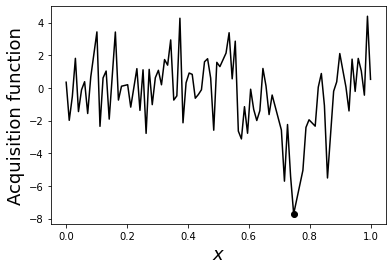

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1253.20it/s, 15 steps of size 1.59e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.49      0.36      0.40      0.05      0.97   2636.32      1.00
         A2      0.56      0.38      0.46      0.09      1.05   2162.33      1.00
k_length[0]      1.73      2.36      1.04      0.06      3.72   5633.71      1.00
    k_scale      1.55      1.85      0.97      0.04      3.41   5604.84      1.00
      noise      2.07      1.10      1.82      0.63      3.46   3416.82      1.00
         w1      0.12      0.06      0.12      0.02      0.22   3948.60      1.00
         w2      0.10      0.05      0.09      0.03      0.17   3138.40      1.00
        x01      0.22      0.10      0.18      0.10      0.38   2806.23      1.00
        x02      0.76      0.04      0.76      0.70      0.83   3463.05      1.00
         y0      3.28      2.40      3.01     -0.62      7.31   1941.25      1.00

Number of divergences: 43


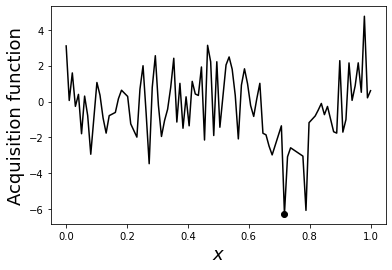

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1083.53it/s, 15 steps of size 1.25e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.50      0.36      0.41      0.05      0.96   3048.42      1.00
         A2      0.55      0.36      0.47      0.10      1.04   2761.13      1.00
k_length[0]      1.75      2.32      1.04      0.05      3.86   5681.99      1.00
    k_scale      1.58      1.86      0.98      0.04      3.51   5622.13      1.00
      noise      1.88      0.96      1.65      0.58      3.11   3768.86      1.00
         w1      0.13      0.06      0.12      0.03      0.23   4967.67      1.00
         w2      0.09      0.05      0.08      0.03      0.16   3048.15      1.00
        x01      0.22      0.10      0.18      0.10      0.38   2944.66      1.00
        x02      0.76      0.04      0.76      0.70      0.81   3026.07      1.00
         y0      3.27      2.34      3.05     -0.33      7.36   2488.86      1.00

Number of divergences: 24


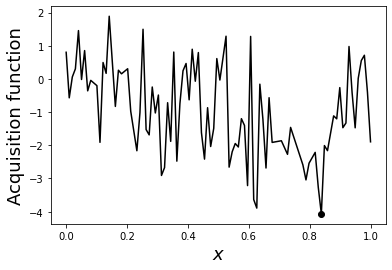

In [17]:
exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP1(1, RBFKernel, mean_fn=doubleLorentzfunc)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10, chain_dim=False)
    # Compute acquisition 
    obj = Thompson(rng_key_predict, gp_model, posterior_samples, X_test, chain_dim=False)
    # FInd maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

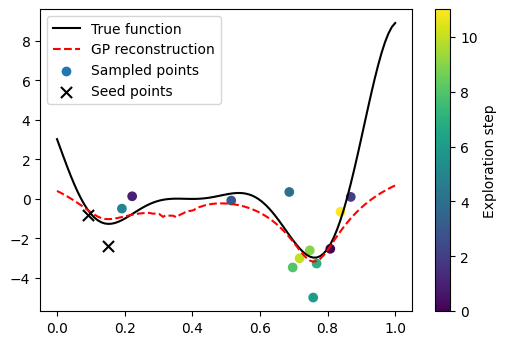

In [18]:
y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)

plot_final_result(X_train, y_train, y_pred)

### Structured GP - UCB

Do Bayesian optimization with upper confidence bound acqusition function:

In [19]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2635.07it/s, 31 steps of size 1.41e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.92      0.67      0.74      0.04      1.87   6013.08      1.00
         A2      1.26      1.07      0.93      0.05      2.73   6650.42      1.00
k_length[0]      1.68      2.20      1.02      0.03      3.68   7064.89      1.00
    k_scale      1.60      2.11      0.97      0.05      3.45   6481.10      1.00
      noise      1.19      1.40      0.77      0.04      2.59   6984.56      1.00
         w1      0.09      0.06      0.08      0.00      0.17   7149.46      1.00
         w2      0.08      0.06      0.07      0.00      0.16   8437.47      1.00
        x01      0.34      0.10      0.35      0.19      0.50   6464.31      1.00
        x02      0.70      0.11      0.70      0.51      0.86   8307.79      1.00
         y0      4.44      2.88      4.48      0.22      9.44   5167.48      1.00

Number of divergences: 60


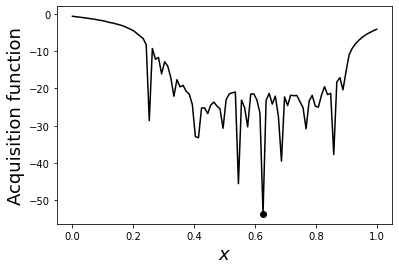

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1987.79it/s, 31 steps of size 1.28e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.87      0.53      0.77      0.10      1.64   4781.72      1.00
         A2      0.51      0.37      0.42      0.05      1.03   5155.06      1.00
k_length[0]      1.67      2.13      1.01      0.04      3.75   6252.25      1.00
    k_scale      1.64      2.11      1.01      0.04      3.57   6470.79      1.00
      noise      1.27      1.49      0.83      0.04      2.66   5399.91      1.00
         w1      0.09      0.06      0.08      0.00      0.17   6072.93      1.00
         w2      0.10      0.07      0.09      0.00      0.19   6561.94      1.00
        x01      0.25      0.07      0.25      0.12      0.36   4182.92      1.00
        x02      0.74      0.12      0.77      0.54      0.90   4406.20      1.00
         y0      4.60      2.54      4.52      0.88      9.27   4023.12      1.00

Number of divergences: 88


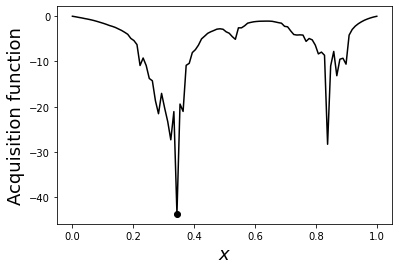

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2145.87it/s, 15 steps of size 1.65e-01. acc. prob=0.73]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.63      0.40      0.53      0.08      1.18   3251.99      1.00
         A2      0.52      0.36      0.43      0.07      1.03   4170.64      1.00
k_length[0]      1.78      2.42      1.06      0.04      3.93   2415.43      1.00
    k_scale      1.59      1.99      0.97      0.04      3.50   5506.77      1.00
      noise      1.06      1.22      0.71      0.03      2.23   5048.61      1.00
         w1      0.11      0.06      0.10      0.00      0.18   3610.97      1.00
         w2      0.10      0.07      0.09      0.00      0.19   5125.41      1.00
        x01      0.20      0.06      0.20      0.11      0.26   2883.76      1.00
        x02      0.74      0.12      0.78      0.55      0.90   3227.77      1.00
         y0      3.86      2.35      3.67      0.27      8.07   3396.13      1.00

Number of divergences: 181


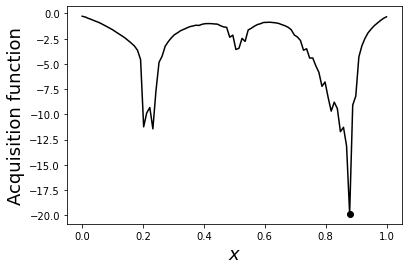

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1948.19it/s, 63 steps of size 1.09e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.67      0.39      0.57      0.13      1.22   3455.31      1.00
         A2      0.41      0.29      0.34      0.05      0.79   4051.97      1.00
k_length[0]      1.72      2.22      1.05      0.04      3.75   5809.99      1.00
    k_scale      1.56      1.87      0.97      0.04      3.46   5180.57      1.00
      noise      0.96      1.01      0.65      0.05      2.06   4580.67      1.00
         w1      0.11      0.06      0.10      0.01      0.19   3968.84      1.00
         w2      0.12      0.07      0.11      0.00      0.21   4036.86      1.00
        x01      0.20      0.05      0.20      0.12      0.25   3185.95      1.00
        x02      0.65      0.10      0.65      0.50      0.77   4105.46      1.00
         y0      4.14      1.97      3.97      0.96      7.45   3353.36      1.00

Number of divergences: 173


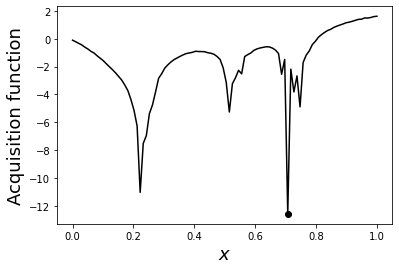

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1650.72it/s, 47 steps of size 9.49e-02. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.83      0.47      0.74      0.16      1.55   1796.09      1.00
         A2      0.46      0.29      0.40      0.09      0.85   1718.34      1.00
k_length[0]      1.65      2.07      1.03      0.05      3.54   4230.03      1.00
    k_scale      1.61      1.95      0.99      0.03      3.52   4021.01      1.00
      noise      1.46      1.52      0.97      0.07      3.27   1624.60      1.00
         w1      0.12      0.06      0.11      0.01      0.20   3139.10      1.00
         w2      0.06      0.05      0.05      0.00      0.13   1301.39      1.01
        x01      0.21      0.06      0.21      0.10      0.26   2220.42      1.00
        x02      0.72      0.05      0.73      0.66      0.79   1835.56      1.00
         y0      4.91      2.36      4.81      1.22      8.97   1596.84      1.00

Number of divergences: 305


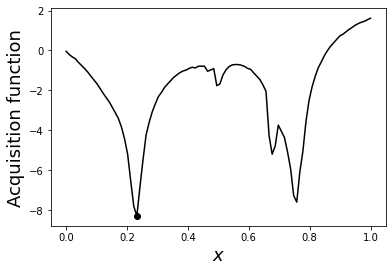

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1671.77it/s, 15 steps of size 1.03e-01. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.69      0.47      0.58      0.06      1.35   1761.94      1.00
         A2      0.46      0.31      0.39      0.09      0.88   2931.75      1.00
k_length[0]      1.72      2.35      1.02      0.04      3.90   3028.42      1.00
    k_scale      1.69      2.06      1.04      0.04      3.77   3284.36      1.00
      noise      1.98      1.57      1.54      0.23      3.87   1615.60      1.01
         w1      0.14      0.06      0.13      0.04      0.23   2841.66      1.00
         w2      0.08      0.06      0.06      0.00      0.16   1504.66      1.00
        x01      0.20      0.09      0.17      0.10      0.35   2071.19      1.01
        x02      0.71      0.06      0.72      0.58      0.80   1658.55      1.01
         y0      4.19      2.33      4.06      0.52      8.16   1732.90      1.00

Number of divergences: 354


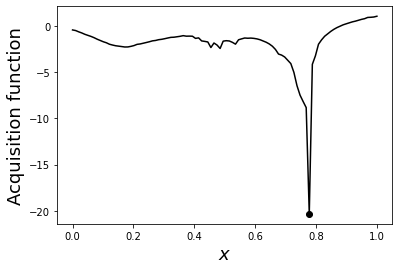

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1500.01it/s, 31 steps of size 9.47e-02. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.68      0.45      0.58      0.08      1.33   2355.33      1.00
         A2      0.48      0.31      0.41      0.08      0.89   2881.80      1.00
k_length[0]      1.68      2.35      0.99      0.05      3.59   5367.31      1.00
    k_scale      1.61      1.98      0.98      0.03      3.58   4463.17      1.00
      noise      1.82      1.41      1.43      0.18      3.54   1800.94      1.01
         w1      0.14      0.06      0.13      0.04      0.23   3443.48      1.00
         w2      0.08      0.05      0.07      0.00      0.15   1522.28      1.01
        x01      0.20      0.09      0.17      0.10      0.36   2348.13      1.00
        x02      0.72      0.05      0.73      0.64      0.82   1977.59      1.00
         y0      4.09      2.36      3.93      0.35      8.24   2420.00      1.00

Number of divergences: 156


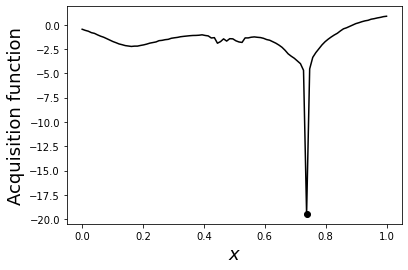

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1370.06it/s, 15 steps of size 1.64e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.63      0.43      0.53      0.06      1.22   2626.53      1.00
         A2      0.53      0.33      0.45      0.09      0.98   3914.53      1.00
k_length[0]      1.72      2.33      1.01      0.05      3.72   5304.07      1.00
    k_scale      1.57      1.92      0.98      0.03      3.43   5484.63      1.00
      noise      1.85      1.23      1.53      0.44      3.46   2937.11      1.00
         w1      0.13      0.06      0.13      0.04      0.23   4336.74      1.00
         w2      0.10      0.05      0.09      0.02      0.17   3550.08      1.00
        x01      0.20      0.10      0.17      0.10      0.37   2528.96      1.00
        x02      0.71      0.05      0.72      0.63      0.80   2953.37      1.00
         y0      3.97      2.38      3.83      0.19      8.08   2443.56      1.00

Number of divergences: 32


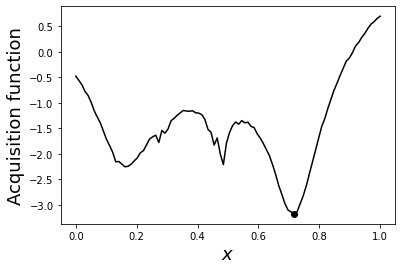

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1357.06it/s, 31 steps of size 1.49e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.67      0.44      0.57      0.07      1.28   2886.22      1.00
         A2      0.53      0.33      0.46      0.09      0.98   3997.28      1.00
k_length[0]      1.72      2.33      1.01      0.03      3.82   5237.19      1.00
    k_scale      1.67      2.03      1.03      0.04      3.71   6090.72      1.00
      noise      1.57      1.06      1.29      0.36      2.88   2501.34      1.00
         w1      0.13      0.06      0.13      0.04      0.22   4608.07      1.00
         w2      0.09      0.05      0.08      0.02      0.16   3180.74      1.00
        x01      0.20      0.09      0.17      0.10      0.33   2159.82      1.00
        x02      0.72      0.05      0.72      0.65      0.78   2048.85      1.00
         y0      4.18      2.40      4.05      0.32      8.38   2340.94      1.00

Number of divergences: 22


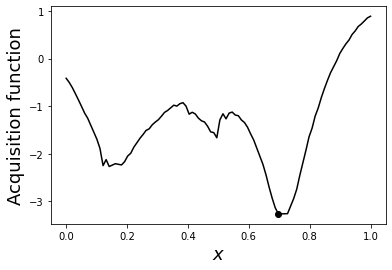

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1271.03it/s, 15 steps of size 1.24e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.69      0.44      0.59      0.07      1.30   3109.40      1.00
         A2      0.53      0.31      0.46      0.11      0.95   3992.64      1.00
k_length[0]      1.65      2.18      0.99      0.03      3.65   6161.26      1.00
    k_scale      1.62      2.00      1.00      0.03      3.65   4606.99      1.00
      noise      1.35      0.88      1.11      0.36      2.52   2421.05      1.01
         w1      0.13      0.06      0.13      0.05      0.23   5110.11      1.00
         w2      0.08      0.04      0.07      0.03      0.14   2960.92      1.00
        x01      0.19      0.08      0.16      0.10      0.30   1972.57      1.01
        x02      0.71      0.03      0.71      0.67      0.76   2528.26      1.00
         y0      4.31      2.34      4.19      0.57      8.28   2694.69      1.00

Number of divergences: 26


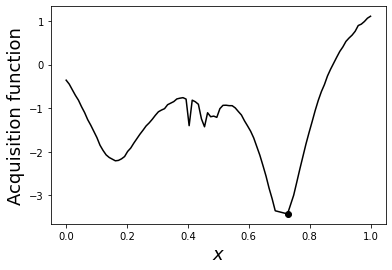

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1157.80it/s, 31 steps of size 9.96e-02. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.70      0.46      0.60      0.08      1.37   1343.16      1.01
         A2      0.53      0.30      0.46      0.12      0.96   2975.64      1.00
k_length[0]      1.68      2.30      0.99      0.03      3.65   5142.17      1.00
    k_scale      1.65      1.97      1.01      0.04      3.66   4769.57      1.00
      noise      1.17      0.72      0.99      0.24      2.01   2390.68      1.00
         w1      0.14      0.06      0.13      0.04      0.22   3991.35      1.00
         w2      0.08      0.04      0.08      0.03      0.13   3090.91      1.00
        x01      0.18      0.08      0.16      0.10      0.28   3109.74      1.00
        x02      0.71      0.03      0.71      0.68      0.75   2497.95      1.00
         y0      4.40      2.32      4.24      0.72      8.38   1911.15      1.01

Number of divergences: 101


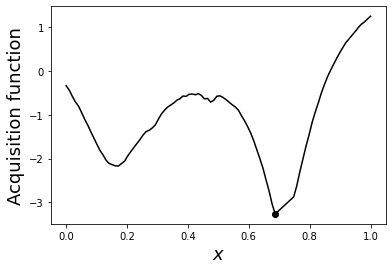

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1119.06it/s, 15 steps of size 1.30e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.65      0.45      0.54      0.07      1.29   2761.69      1.00
         A2      0.53      0.34      0.45      0.08      1.00   3830.10      1.00
k_length[0]      1.68      2.33      1.01      0.02      3.59   6024.82      1.00
    k_scale      1.60      1.97      0.99      0.04      3.52   5907.95      1.00
      noise      1.95      1.03      1.71      0.61      3.26   3179.48      1.00
         w1      0.13      0.06      0.13      0.04      0.23   6052.15      1.00
         w2      0.10      0.05      0.09      0.03      0.17   3677.20      1.00
        x01      0.21      0.10      0.17      0.10      0.37   2669.48      1.00
        x02      0.72      0.05      0.73      0.65      0.80   1448.99      1.01
         y0      4.04      2.48      3.84      0.24      8.49   2454.26      1.00

Number of divergences: 11


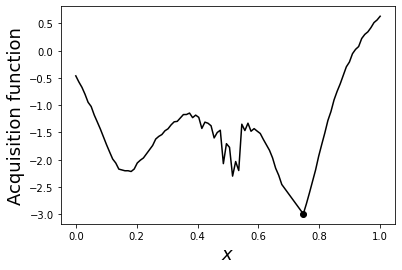

In [20]:
exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP1(1, RBFKernel, mean_fn=doubleLorentzfunc)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10)
    # Compute acquisition 
    obj = UCB(rng_key_predict, gp_model, posterior_samples, X_test)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

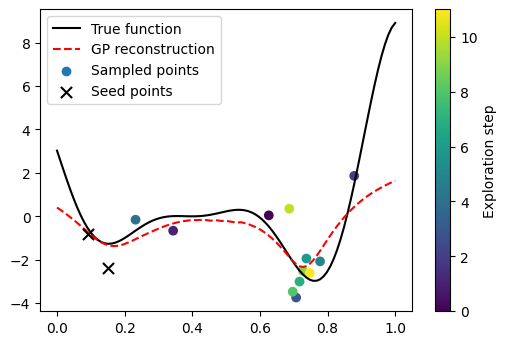

In [21]:
y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)

plot_final_result(X_train, y_train, y_pred)

### Structured GP - wrong function - Thompson

Here we will use a function that is a 'wrong' function, but still partially captures some trends in data.

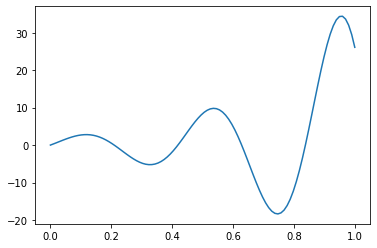

In [22]:
def oscfunc(x, params):
    return params["A"] * jnp.exp(params["a"] * x) * jnp.sin(params["b"] * x)

x = jnp.linspace(0, 1, 100)
y = oscfunc(x, {"a": 3, "b": 15, "A": 2})
plt.plot(x, y)

In [23]:
class GP2(ExactGP):

    def __init__(self, input_dim, kernel, mean_fn):
        super(GP2, self).__init__(input_dim, kernel, mean_fn)

    def model(self, X, y):

        f_loc = jnp.zeros(X.shape[0])

        # Mean function prameters
        a = numpyro.sample("a", dist.Normal(1, 2))
        b = numpyro.sample("b", dist.Normal(10, 5))
        A = numpyro.sample("A", dist.LogNormal(0, 1))
        # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"a": a, "b": b, "A": A}
        if self.mean_fn is not None:
            f_loc += self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

In [24]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4125.65it/s, 7 steps of size 5.25e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.86      0.87      0.61      0.04      1.82   3353.06      1.00
          a      0.69      2.01      0.67     -2.52      4.03   6304.23      1.00
          b      9.56      6.50      9.70     -1.71     19.79   4760.37      1.00
k_length[0]      1.63      2.11      0.99      0.05      3.50   8511.16      1.00
    k_scale      2.04      2.24      1.37      0.08      4.38   8173.93      1.00
      noise      1.92      2.04      1.32      0.09      3.98   7208.38      1.00

Number of divergences: 22


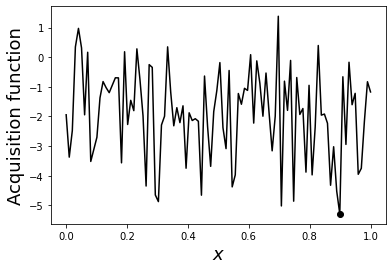

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2303.38it/s, 79 steps of size 4.96e-02. acc. prob=0.80]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.86      0.80      0.65      0.05      1.71   1112.35      1.01
          a      1.49      1.65      1.79     -1.23      3.99   1019.89      1.01
          b      9.67      6.40      9.23     -0.06     18.82    217.04      1.04
k_length[0]      1.36      1.89      0.73      0.04      3.19   1157.59      1.01
    k_scale      2.24      2.60      1.49      0.05      4.79   2532.82      1.00
      noise      2.53      2.47      1.78      0.09      5.36   1880.56      1.01

Number of divergences: 203


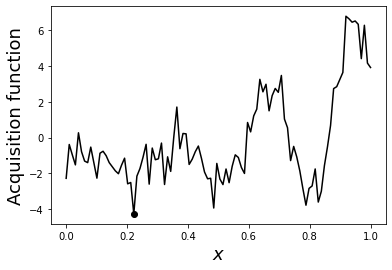

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2085.12it/s, 63 steps of size 6.02e-02. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.83      0.74      0.62      0.06      1.69   1477.68      1.01
          a      1.44      1.64      1.73     -1.20      3.96   1355.11      1.01
          b      8.08      5.58      8.36      0.45     16.45    312.59      1.04
k_length[0]      1.36      1.84      0.76      0.02      3.06   2165.88      1.00
    k_scale      1.96      2.53      1.23      0.03      4.13   3569.80      1.00
      noise      2.52      2.22      1.87      0.31      5.05   2196.29      1.00

Number of divergences: 143


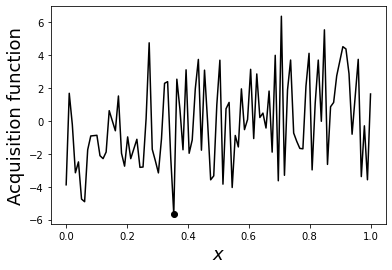

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2213.77it/s, 39 steps of size 7.81e-02. acc. prob=0.72]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.80      0.79      0.59      0.06      1.58    708.00      1.01
          a      1.46      1.68      1.73     -0.90      4.55    543.51      1.01
          b      7.37      5.60      7.86      0.29     16.13    283.39      1.03
k_length[0]      1.32      1.72      0.75      0.04      2.86   1870.97      1.01
    k_scale      1.87      2.38      1.13      0.04      4.08   3113.28      1.00
      noise      2.19      1.85      1.67      0.26      4.40   1552.45      1.01

Number of divergences: 167


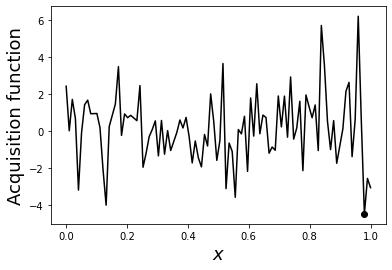

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2522.21it/s, 15 steps of size 1.22e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.79      0.67      0.64      0.07      1.42     84.21      1.06
          a      2.90      0.90      2.86      1.63      4.22     23.31      1.15
          b      6.13      4.33      7.64      0.11     13.64      6.68      2.94
k_length[0]      1.48      1.98      0.99      0.03      2.99   4552.34      1.00
    k_scale      1.69      1.99      1.15      0.04      3.49   4279.07      1.01
      noise      1.80      1.54      1.37      0.33      3.54     78.25      1.06

Number of divergences: 710


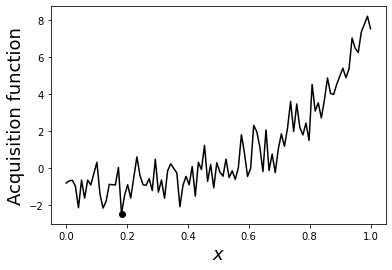

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1799.67it/s, 63 steps of size 6.23e-02. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.75      0.71      0.56      0.07      1.47    180.55      1.05
          a      2.79      0.85      2.82      1.51      4.15   1579.60      1.01
          b      5.74      3.62      7.59      0.46      8.42      8.75      1.76
k_length[0]      1.42      1.96      0.85      0.03      3.03   2256.31      1.00
    k_scale      1.89      2.22      1.27      0.05      4.00   3035.76      1.01
      noise      1.58      1.25      1.25      0.28      2.97   1628.36      1.01

Number of divergences: 171


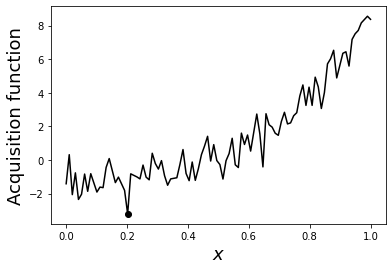

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1855.77it/s, 31 steps of size 1.43e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.61      0.51      0.45      0.06      1.20    168.09      1.04
          a      2.99      0.97      3.01      1.75      4.50     58.28      1.09
          b      6.94      4.70      7.72      0.25     14.57     10.14      1.71
k_length[0]      1.47      1.98      0.88      0.04      2.91   1399.91      1.02
    k_scale      2.24      2.61      1.55      0.08      4.56   2357.20      1.01
      noise      1.58      1.25      1.24      0.35      2.94    299.72      1.03

Number of divergences: 456


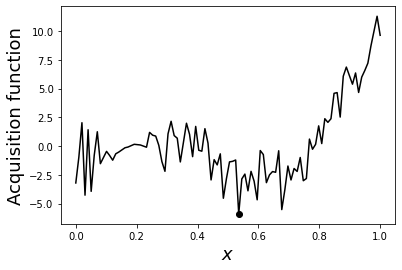

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:04<00:00, 722.04it/s, 255 steps of size 1.37e-02. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.52      0.48      0.39      0.05      1.03     91.77      1.07
          a      3.08      1.06      3.15      1.78      4.94    600.03      1.02
          b      7.15      5.24      7.61      0.40     14.84     10.93      1.69
k_length[0]      1.11      1.59      0.57      0.04      2.62    121.04      1.04
    k_scale      2.22      2.65      1.46      0.08      4.82    806.72      1.02
      noise      1.66      1.27      1.31      0.33      3.13   1239.24      1.01

Number of divergences: 221


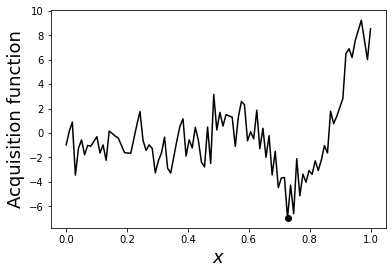

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1774.43it/s, 15 steps of size 1.41e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.37      0.27      0.30      0.05      0.70   1710.18      1.02
          a      3.33      0.83      3.37      2.09      4.64   2462.35      1.01
          b     10.85      4.21      8.02      7.13     15.11      5.78      3.63
k_length[0]      1.05      1.68      0.54      0.03      2.35   1924.21      1.01
    k_scale      1.83      2.06      1.21      0.06      3.85   2163.56      1.01
      noise      1.76      1.25      1.44      0.37      3.27    333.88      1.03

Number of divergences: 2


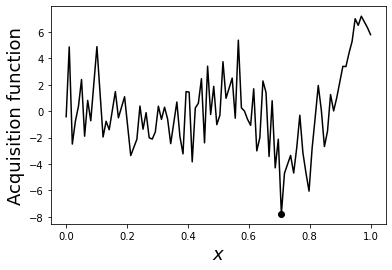

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1559.95it/s, 31 steps of size 1.51e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.40      0.29      0.33      0.06      0.75   1925.04      1.02
          a      3.32      0.76      3.34      2.13      4.57   2765.82      1.01
          b      9.09      2.84      7.77      7.18     14.91      5.06      9.17
k_length[0]      1.06      1.64      0.55      0.05      2.41   4049.47      1.01
    k_scale      1.87      2.08      1.25      0.06      3.96   4502.04      1.01
      noise      1.66      1.04      1.41      0.40      2.96   3901.29      1.00

Number of divergences: 0


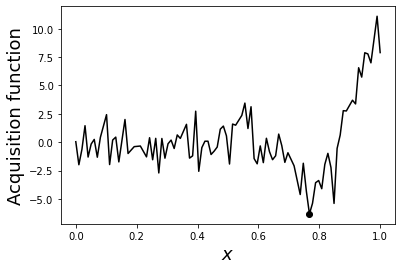

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1395.77it/s, 15 steps of size 1.32e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.37      0.27      0.30      0.05      0.69    149.19      1.04
          a      3.45      0.78      3.46      2.19      4.66   1367.32      1.02
          b     10.45      3.53      7.85      7.21     15.03      5.03     13.46
k_length[0]      1.10      1.67      0.59      0.04      2.56   4087.86      1.01
    k_scale      1.73      1.90      1.18      0.04      3.67   2551.02      1.01
      noise      1.59      0.93      1.37      0.42      2.77   4275.53      1.00

Number of divergences: 0


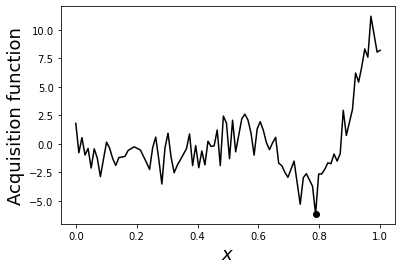

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1361.20it/s, 31 steps of size 1.25e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.39      0.34      0.30      0.04      0.73    233.38      1.05
          a      3.44      0.82      3.46      2.18      4.74    712.32      1.02
          b      9.57      4.42      7.69      7.09     15.11     10.50      7.73
k_length[0]      0.98      1.48      0.51      0.05      2.28   4256.52      1.00
    k_scale      1.93      2.29      1.25      0.07      4.08    460.34      1.02
      noise      1.44      0.87      1.24      0.34      2.47   2319.59      1.01

Number of divergences: 3


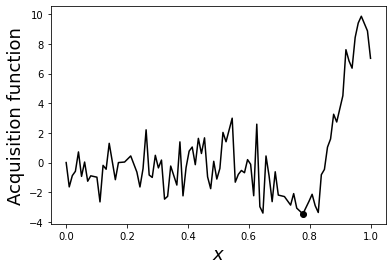

In [25]:
exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP2(1, RBFKernel, mean_fn=oscfunc)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10)
    # Compute acquisition 
    obj = Thompson(rng_key_predict, gp_model, posterior_samples, X_test)
    # FInd maximum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

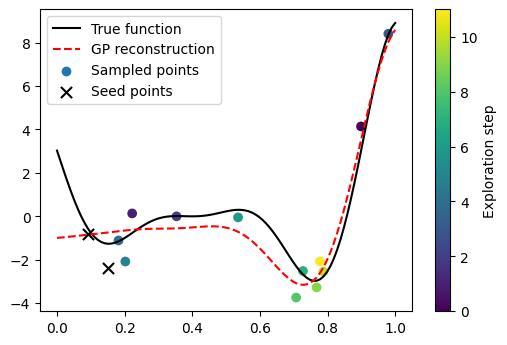

In [26]:
y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)

plot_final_result(X_train, y_train, y_pred)

### Structured GP - wrong function - UCB

In [27]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:00<00:00, 4290.29it/s, 7 steps of size 5.25e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.86      0.87      0.61      0.04      1.82   3353.06      1.00
          a      0.69      2.01      0.67     -2.52      4.03   6304.23      1.00
          b      9.56      6.50      9.70     -1.71     19.79   4760.37      1.00
k_length[0]      1.63      2.11      0.99      0.05      3.50   8511.16      1.00
    k_scale      2.04      2.24      1.37      0.08      4.38   8173.93      1.00
      noise      1.92      2.04      1.32      0.09      3.98   7208.38      1.00

Number of divergences: 22


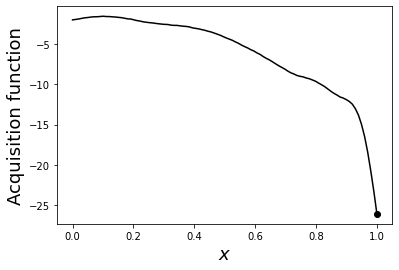

2/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2701.24it/s, 31 steps of size 9.08e-02. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      1.11      1.02      0.85      0.08      2.24     88.53      1.08
          a      2.71      0.97      2.78      1.23      4.22    110.95      1.06
          b      8.80      7.59      8.32      0.37     21.26     11.30      2.08
k_length[0]      1.48      2.01      0.88      0.05      3.18   2023.71      1.01
    k_scale      2.10      2.76      1.30      0.07      4.44   1430.61      1.01
      noise      2.47      2.70      1.63      0.08      5.15    259.46      1.03

Number of divergences: 634


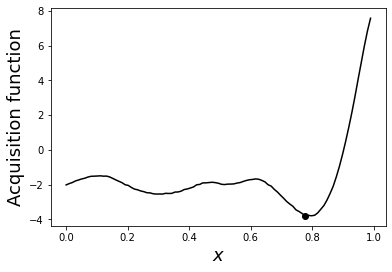

3/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2564.26it/s, 31 steps of size 6.25e-02. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.86      0.78      0.63      0.08      1.76     26.36      1.14
          a      2.75      0.93      2.77      1.40      4.17   1170.94      1.02
          b      9.87      6.64      8.04     -3.89     20.49      5.91      3.53
k_length[0]      1.48      1.99      0.85      0.05      3.32   2606.72      1.00
    k_scale      2.08      2.36      1.36      0.05      4.42   2367.12      1.01
      noise      2.46      2.85      1.56      0.10      5.34    397.91      1.03

Number of divergences: 174


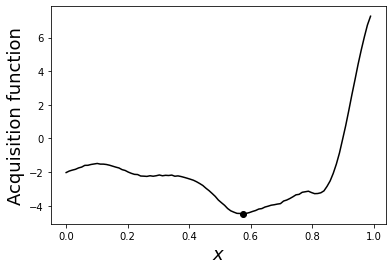

4/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2183.79it/s, 111 steps of size 4.11e-02. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.55      0.46      0.43      0.06      1.12   1072.57      1.02
          a      2.95      1.05      3.03      1.31      4.52   1092.86      1.01
          b     14.36      3.93     14.21      7.82     21.42     13.71      1.46
k_length[0]      1.08      1.66      0.54      0.02      2.36   1071.97      1.01
    k_scale      2.12      2.55      1.29      0.04      4.87   2124.91      1.00
      noise      3.32      3.31      2.39      0.10      6.89    630.80      1.02

Number of divergences: 220


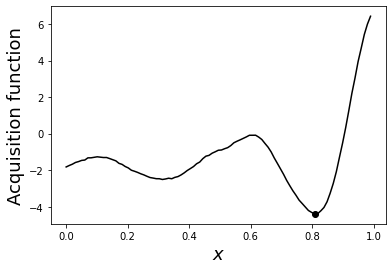

5/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2064.65it/s, 31 steps of size 6.94e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.48      0.45      0.36      0.05      0.94   1849.41      1.01
          a      3.06      1.08      3.15      1.56      4.67    885.75      1.02
          b     12.67      3.93     14.10      7.10     15.16     10.30      1.82
k_length[0]      0.90      1.37      0.49      0.02      1.93   3312.84      1.01
    k_scale      2.23      2.68      1.46      0.04      4.80   4025.40      1.00
      noise      2.79      2.96      1.87      0.13      6.04    105.35      1.07

Number of divergences: 24


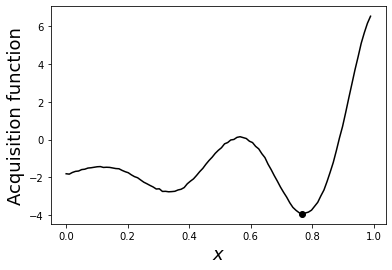

6/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1903.04it/s, 31 steps of size 1.09e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.44      0.36      0.34      0.05      0.86   2987.67      1.00
          a      3.20      0.93      3.22      1.76      4.66   2346.76      1.00
          b     13.40      2.37     14.20      7.44     15.13      6.46      2.60
k_length[0]      0.82      1.28      0.46      0.03      1.66   4217.96      1.00
    k_scale      2.30      2.50      1.54      0.06      5.00   4681.32      1.00
      noise      2.04      2.01      1.44      0.16      4.24    187.21      1.03

Number of divergences: 25


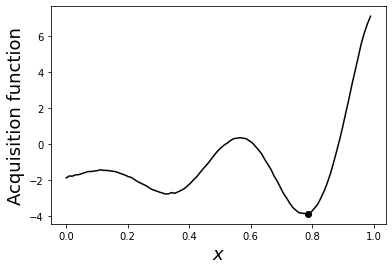

7/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2013.26it/s, 31 steps of size 7.96e-02. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.43      0.39      0.33      0.05      0.84   2483.83      1.00
          a      3.23      0.94      3.26      1.92      4.78   1932.54      1.01
          b     12.75      3.05     14.14      7.03     15.00      6.09      3.00
k_length[0]      0.73      1.24      0.41      0.04      1.41   3273.46      1.00
    k_scale      2.63      2.83      1.77      0.05      5.93   2881.12      1.00
      noise      1.67      1.80      1.13      0.17      3.55    217.32      1.04

Number of divergences: 82


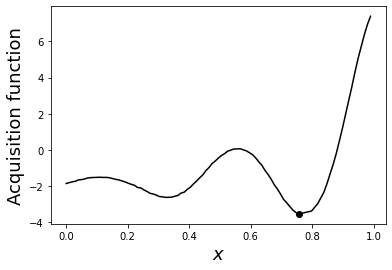

8/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1683.95it/s, 31 steps of size 1.07e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.48      0.39      0.37      0.06      0.94   3238.20      1.00
          a      3.19      0.87      3.22      1.75      4.57   3111.89      1.00
          b     13.06      2.95     14.43      7.15     15.21      5.10      7.29
k_length[0]      0.92      1.79      0.50      0.04      1.92   4915.79      1.00
    k_scale      2.18      2.77      1.38      0.05      4.73   4859.76      1.00
      noise      2.20      1.65      1.73      0.40      4.22    119.35      1.04

Number of divergences: 2


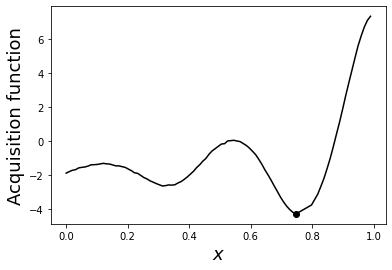

9/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:01<00:00, 1572.09it/s, 31 steps of size 1.06e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.46      0.37      0.36      0.05      0.87   3108.58      1.00
          a      3.30      0.86      3.32      1.93      4.70   2706.10      1.00
          b     10.11      3.56      7.49      6.82     14.89      5.05     10.67
k_length[0]      1.00      1.91      0.51      0.04      2.23   5303.84      1.00
    k_scale      2.12      2.62      1.29      0.04      4.77   3596.57      1.00
      noise      2.28      1.57      1.89      0.44      4.17    109.17      1.04

Number of divergences: 0


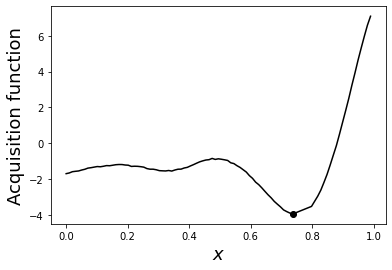

10/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1461.02it/s, 31 steps of size 9.58e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.43      0.34      0.34      0.05      0.82   3233.90      1.00
          a      3.31      0.88      3.34      1.96      4.69   2384.48      1.01
          b     10.77      3.58     12.05      6.81     14.78      5.05     10.15
k_length[0]      0.90      1.49      0.47      0.03      1.95   3588.13      1.01
    k_scale      2.21      2.65      1.38      0.04      4.88   3367.84      1.00
      noise      2.06      1.37      1.70      0.43      3.76    110.66      1.04

Number of divergences: 2


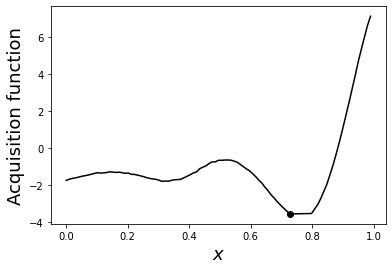

11/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1239.18it/s, 31 steps of size 8.14e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.42      0.36      0.33      0.06      0.82   1745.59      1.00
          a      3.35      0.88      3.38      2.00      4.74   1133.85      1.02
          b     10.33      3.64      7.55      6.76     14.74      5.94      3.72
k_length[0]      0.84      1.57      0.44      0.04      1.82   4301.34      1.00
    k_scale      2.39      2.93      1.50      0.03      5.38   1675.75      1.00
      noise      1.80      1.17      1.49      0.37      3.29    121.38      1.04

Number of divergences: 1


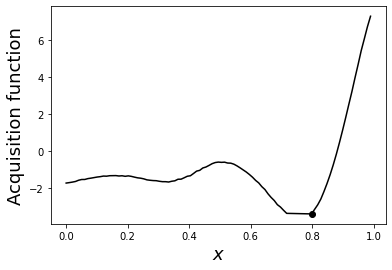

12/12


/usr/local/lib/python3.7/dist-packages/numpyro/infer/mcmc.py:275: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1143.01it/s, 15 steps of size 1.22e-01. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.43      0.38      0.33      0.05      0.83   1184.61      1.01
          a      3.31      0.90      3.35      1.94      4.75   1172.06      1.01
          b     10.62      4.10     10.84      6.79     14.87      5.66      3.58
k_length[0]      0.75      1.17      0.41      0.03      1.58   3837.73      1.00
    k_scale      2.49      2.89      1.61      0.06      5.48   1691.93      1.01
      noise      1.65      1.05      1.38      0.40      2.95    110.37      1.04

Number of divergences: 5


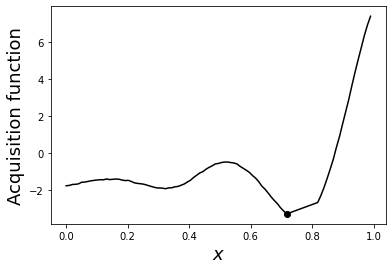

In [28]:
exploration_steps = 12

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP2(1, RBFKernel, mean_fn=oscfunc)
    # Get/update GP posterior
    posterior_samples = gp_model.fit(rng_key, X_train, y_train, num_chains=10)
    # Compute acquisition 
    obj = UCB(rng_key_predict, gp_model, posterior_samples, X_test)
    # FInd maximum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

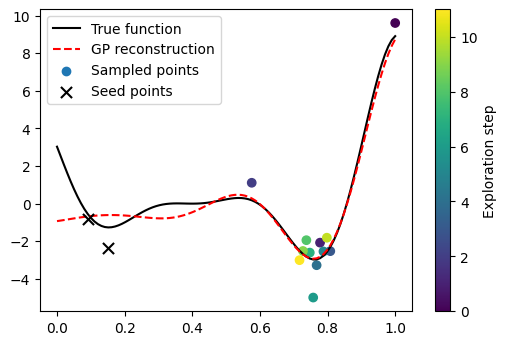

In [29]:
y_pred, _ = gp_model.predict(rng_key_predict, posterior_samples, X)

plot_final_result(X_train, y_train, y_pred)